### Model creation and building

We want to use the keras API to create an deep model which utilizes a simple LSTM network in order to predict the BTC price at the next step. 

In [1]:
import pandas as pd 
import tensorflow as tf 

from tensorflow import keras


2023-07-17 17:28:07.311836: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-17 17:28:07.380178: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-17 17:28:07.698697: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-17 17:28:07.700768: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 17:28:09.333302: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
features = pd.read_csv("features.csv", index_col=0) # Precomputed features we have from earlier
btc_price_data = pd.read_parquet('btc_usd_1h.parquet')

close_price = btc_price_data['close']
features['btc_close_price'] = close_price

In [3]:
# We want to predict the bitcion price one step ahead so we need to shift this one back
target_price = close_price.shift(-1)
target_price.name = 'target_bitcoin_price'

all_data = pd.concat([features, target_price], axis = 1)
all_data.dropna(inplace=True)

In [5]:
class BTCLSTMModel(keras.Model):

    def __init__(self, lstm_units_1: int = 32, lstm_units_2 = 64, name: str = 'BTC_LSTM_Model', **kwargs): 
        super().__init__(name = name, **kwargs)

        self.lstm_1 = keras.layers.LSTM(units = lstm_units_1, return_sequences=True)
        self.lstm_2 = keras.layers.LSTM(units = lstm_units_2, return_sequences=False)
        self.dense = keras.layers.Dense(1)

    def call(self, inputs): 

        x = self.lstm_1(inputs)
        x = self.lstm_2(x)
        return self.dense(x)

In [6]:
# Separating into training, validation, and testing data(
data_offset = 24 # Introducing an offset in when we are going to take new data between train, val, and test
train_pct = 0.6

train_examples_number = int(0.6 * len(all_data))

In [7]:
train_data = all_data.iloc[:train_examples_number]
val_and_test = all_data.iloc[(train_examples_number+data_offset):]
validation_data = val_and_test.iloc[:4000]
test_data = val_and_test.iloc[(4000+data_offset):]

In [8]:
# Then we are going to scale each of the columns in our dataset using robust scaling
from sklearn.preprocessing import RobustScaler, StandardScaler

rob_scaler = RobustScaler()
rob_scaler.fit(train_data)

train_data_scaled = rob_scaler.transform(train_data)
val_data_scaled = rob_scaler.transform(validation_data)
test_data_scaled = rob_scaler.transform(test_data)

# Separating out features and target
train_features = train_data_scaled[:, :-1]
train_target = train_data_scaled[:, -1]

val_features = val_data_scaled[:, :-1]
val_target = val_data_scaled[:, -1]

test_features = test_data_scaled[:, :-1]
test_target = test_data_scaled[:, -1]

In [9]:
# Given that we have this processed, we can 
train_time_series_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data = train_features, 
    targets=train_target, 
    sequence_length=24, 
    batch_size=32, 
    shuffle=False
)

validation_time_series_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data = val_features, 
    targets=val_target, 
    sequence_length=24, 
    batch_size=32, 
    shuffle=False
)

test_time_series_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data = test_features, 
    targets=test_target, 
    sequence_length=24, 
    batch_size=32, 
    shuffle=False
)

### Initial model training

We are going to use this training data and run our first model fit here. We are going to run with the following parameters: 
* Epochs = 50
* Adam optimizer with the usual learning rate of 1e-3
* Mean Squared Error Loss
* We will add an early stopping callback where we monitor the validation loss. If it does not change after 5 epochs, we are going to stop the model

After that, we will look at the predictions that come from the model and assess how good it is doing. 

In [10]:
model = BTCLSTMModel(
    lstm_units_1=32, 
    lstm_units_2=64, 
    name = 'BTC_Model_1'
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), 
    loss = tf.keras.losses.MeanSquaredError(), 
    metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()]
)


In [11]:
num_epochs = 50
history = model.fit(
    x = train_time_series_dataset, 
    validation_data=validation_time_series_dataset, 
    epochs=num_epochs, 
    callbacks=[early_stopping_callback]
)

Epoch 1/50


2023-07-17 17:28:59.800250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [13130]
	 [[{{node Placeholder/_20}}]]
2023-07-17 17:28:59.800687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-07-17 17:29:00.300632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype in

410/410 [==============================] - ETA: 0s - loss: 0.0822 - mean_squared_error: 0.0822 - mean_absolute_error: 0.2186

2023-07-17 17:29:14.987343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [3977]
	 [[{{node Placeholder/_8}}]]
2023-07-17 17:29:14.987810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-07-17 17:29:15.315626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32


410/410 [==============================] - 17s 30ms/step - loss: 0.0822 - mean_squared_error: 0.0822 - mean_absolute_error: 0.2186 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - val_mean_absolute_error: 0.3883
Epoch 2/50
410/410 [==============================] - 11s 28ms/step - loss: 0.0535 - mean_squared_error: 0.0535 - mean_absolute_error: 0.1717 - val_loss: 0.0880 - val_mean_squared_error: 0.0880 - val_mean_absolute_error: 0.2429
Epoch 3/50
410/410 [==============================] - 11s 27ms/step - loss: 0.0306 - mean_squared_error: 0.0306 - mean_absolute_error: 0.1273 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1257
Epoch 4/50
410/410 [==============================] - 13s 31ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - mean_absolute_error: 0.1014 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1401
Epoch 5/50
410/410 [==============================] - 13s 31ms/step - loss: 0.0146 - mean_squared_e

In [14]:
history_df = pd.DataFrame(history.history)

<Axes: >

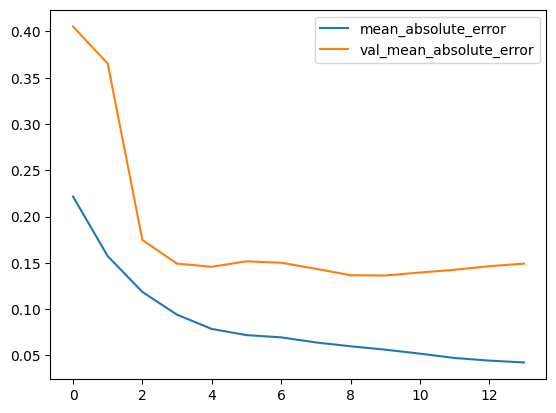

In [18]:
history_df[['mean_absolute_error', 'val_mean_absolute_error']].plot()

In [28]:
val_predictions = model.predict(x = validation_time_series_dataset)
train_predictions = model.predict(x = train_time_series_dataset)

410/410 [==============================] - 3s 7ms/step


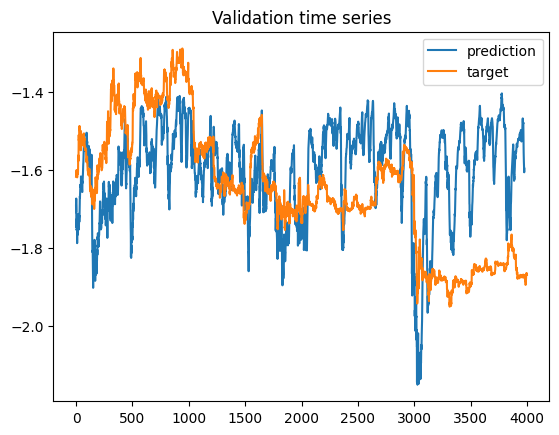

In [33]:
import matplotlib.pyplot as plt

plt.plot(val_predictions, label = 'prediction')
plt.plot(val_target, label = 'target')
plt.title("Validation time series")
plt.legend()
plt.show()

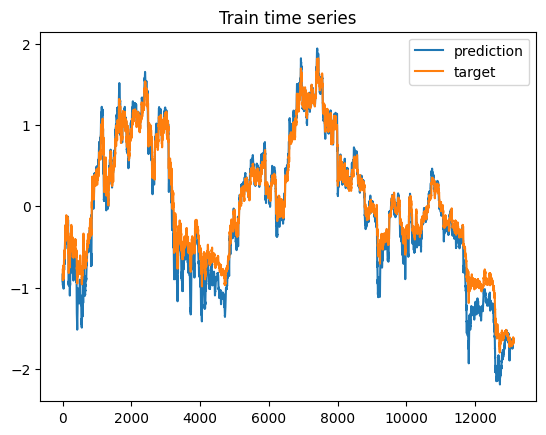

In [34]:
plt.plot(train_predictions, label = 'prediction')
plt.plot(train_target, label = 'target')
plt.title("Train time series")
plt.legend()
plt.show()

In [30]:
model.evaluate(test_time_series_dataset)

147/147 [==============================] - 1s 8ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1907


[0.04762532189488411, 0.04762532189488411, 0.19070221483707428]

### Initial conclusion

We did an initial crack at creating a deep LSTM model to predict the next hour's close price of bitcoin. The steps that we took were: 
* Created our first subclassed model from `keras.Model` where we have two LSTM units one after the other
    * Two LSTM layers with differing sizes 
    * One dense layer at the end with a linear activation
* Used technical analysis features as potential things that the model can learn from
* Input sequences of these indicators into the model
* Did robust scaling of the entire dataset (features and target)
* Fit for 50 epochs, stopped at 14 epochs based on `EarlyStopping` with patience of 5 on the validation loss

When inspecting the model on the validation set, we see that there is a ton of volatility in the predictions compared to what the actual price series did. This might suggest that we need to tune this model or something. The parameters that we can try out are: 
* Different number of LSTM units in each of the layers
* Different type of feature scaling -> StandardScaler? MinMaxScaler? 
* Have a different lookback period for our data? We did a 24 period window but maybe it can be longer than that. 
* Maybe we can add some layers in between the LSTM units which do some normalization on the data? 

Training with 12 period lookback for shits and giggles

In [35]:
# Given that we have this processed, we can 
train_time_series_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data = train_features, 
    targets=train_target, 
    sequence_length=12, 
    batch_size=32, 
    shuffle=False
)

validation_time_series_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data = val_features, 
    targets=val_target, 
    sequence_length=12, 
    batch_size=32, 
    shuffle=False
)

test_time_series_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data = test_features, 
    targets=test_target, 
    sequence_length=12, 
    batch_size=32, 
    shuffle=False
)

In [36]:
model2 = BTCLSTMModel(
    lstm_units_1=32, 
    lstm_units_2=64, 
    name = 'BTC_Model_1'
)

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), 
    loss = tf.keras.losses.MeanSquaredError(), 
    metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()]
)

num_epochs = 50
history2 = model2.fit(
    x = train_time_series_dataset, 
    validation_data=validation_time_series_dataset, 
    epochs=num_epochs, 
    callbacks=[early_stopping_callback]
)

Epoch 1/50


2023-07-12 18:59:15.041837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-07-12 18:59:15.042243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [13119]
	 [[{{node Placeholder/_28}}]]
2023-07-12 18:59:15.218590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int

405/410 [============================>.] - ETA: 0s - loss: 0.0659 - mean_squared_error: 0.0659 - mean_absolute_error: 0.1889

2023-07-12 18:59:21.405708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-07-12 18:59:21.406064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [3989]
	 [[{{node Placeholder/_8}}]]
2023-07-12 18:59:21.550024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32


410/410 [==============================] - 7s 12ms/step - loss: 0.0661 - mean_squared_error: 0.0661 - mean_absolute_error: 0.1897 - val_loss: 0.1107 - val_mean_squared_error: 0.1107 - val_mean_absolute_error: 0.2843
Epoch 2/50
410/410 [==============================] - 5s 12ms/step - loss: 0.0372 - mean_squared_error: 0.0372 - mean_absolute_error: 0.1391 - val_loss: 0.1175 - val_mean_squared_error: 0.1175 - val_mean_absolute_error: 0.2990
Epoch 3/50
410/410 [==============================] - 5s 11ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1015 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1393
Epoch 4/50
410/410 [==============================] - 5s 11ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0837 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1339
Epoch 5/50
410/410 [==============================] - 6s 14ms/step - loss: 0.0106 - mean_squared_error:

In [39]:
history2_df = pd.DataFrame(history2.history)
history_df

,loss,mean_squared_error,mean_absolute_error,val_loss,val_mean_squared_error,val_mean_absolute_error
0,0.087547,0.087547,0.221630,0.206873,0.206873,0.405351
1,0.046823,0.046823,0.157274,0.169345,0.169345,0.365253
2,0.026885,0.026885,0.118587,0.049776,0.049776,0.174611
3,0.017045,0.017045,0.093981,0.034390,0.034390,0.149171
4,0.012252,0.012252,0.078614,0.030883,0.030883,0.145773
5,0.010286,0.010286,0.071943,0.031626,0.031626,0.151689
6,0.009559,0.009559,0.069526,0.031065,0.031065,0.150112
7,0.008097,0.008097,0.064044,0.028374,0.028374,0.143622
8,0.006840,0.006840,0.059896,0.025955,0.025955,0.136646
9,0.005852,0.005852,0.056260,0.026187,0.026187,0.136335


<Axes: >

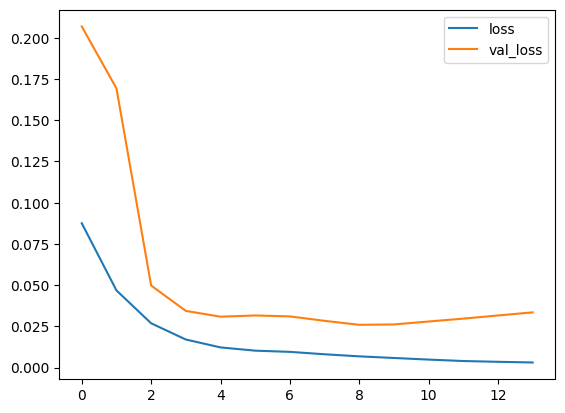

In [41]:
history_df[['loss', 'val_loss']].plot()

410/410 [==============================] - 2s 4ms/step


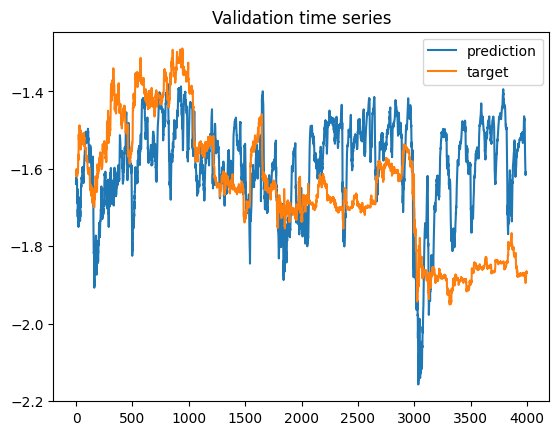

In [42]:
val_predictions = model.predict(x = validation_time_series_dataset)
train_predictions = model.predict(x = train_time_series_dataset)

plt.plot(val_predictions, label = 'prediction')
plt.plot(val_target, label = 'target')
plt.title("Validation time series")
plt.legend()
plt.show()